## Generate Images

In [345]:
from PIL import Image, ImageDraw
import math
import os
import random
import matplotlib.pyplot as plt


def create_square_image(center, square_size, angle, folder, filename):
    size = (64, 64)  # Image size
    image = Image.new("L", size, "white")  # Create a new white image
    draw = ImageDraw.Draw(image)  # Create a draw object

    # Calculate the coordinates of the square's corners before rotation
    half_size = square_size / 2
    corners = [
        (center[0] - half_size, center[1] - half_size),
        (center[0] + half_size, center[1] - half_size),
        (center[0] + half_size, center[1] + half_size),
        (center[0] - half_size, center[1] + half_size),
    ]

    # Rotate the square
    theta = math.radians(angle)  # Convert angle to radians
    rotated_corners = []
    for x, y in corners:
        # Translate point to origin
        temp_x = x - center[0]
        temp_y = y - center[1]
        # Rotate point
        rotated_x = temp_x * math.cos(theta) - temp_y * math.sin(theta)
        rotated_y = temp_x * math.sin(theta) + temp_y * math.cos(theta)
        # Translate point back
        rotated_x += center[0]
        rotated_y += center[1]
        rotated_corners.append((rotated_x, rotated_y))

    # Draw the rotated square
    draw.polygon(rotated_corners, outline="black")

    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Save the image
    image_path = os.path.join(folder, filename)
    image.save(image_path)

def create_triangle_image(center, size, angle, folder, filename):
    image_size = (64, 64)  # Image size
    image = Image.new("L", image_size, "white")  # Create a new white image
    draw = ImageDraw.Draw(image)  # Create a draw object

    # Calculate the triangle's vertices before rotation
    # Assuming an equilateral triangle for simplicity
    height = size * math.sqrt(3) / 2
    vertices = [
        (center[0], center[1] - 2/3 * height),  # Top vertex
        (center[0] - size/2, center[1] + 1/3 * height),  # Bottom left vertex
        (center[0] + size/2, center[1] + 1/3 * height),  # Bottom right vertex
    ]

    # Rotate the triangle
    theta = math.radians(angle)  # Angle in radians
    rotated_vertices = []
    for x, y in vertices:
        # Translate point to origin (center), rotate, translate back
        temp_x = x - center[0]
        temp_y = y - center[1]
        rotated_x = temp_x * math.cos(theta) - temp_y * math.sin(theta) + center[0]
        rotated_y = temp_x * math.sin(theta) + temp_y * math.cos(theta) + center[1]
        rotated_vertices.append((rotated_x, rotated_y))

    # Draw the rotated triangle
    draw.polygon(rotated_vertices, outline="black")

    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Save the image
    image_path = os.path.join(folder, filename)
    image.save(image_path)

# Example usage
folder_name = "Training"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Generate 30 triangles with varying sizes and orientations
for i in range(10):
    center = (random.randint(32, 32),random.randint(32, 32))  # Center of the image
    size = random.randint(16, 24)  # Random size
    angle = random.choice([0])  # Random orientation
    filename = f"triangle_{i}.png"
    create_triangle_image(center, size, angle, folder_name, filename)

for i in range(10):
    center = (random.randint(32, 32), random.randint(32, 32))
    square_size = random.randint(16, 24)
    angle = 0
    filename = f"square_{i}.png"
    create_square_image(center, square_size, angle, folder_name, filename)

## Deep Boltzmann Machine

In [405]:
import numpy as np

np.random.seed(1401)

class RBM:
	def __init__(self, n_visible, n_hidden):
		self.weights = np.random.randn(n_visible, n_hidden) * 0.1
		self.hidden_bias = np.random.randn(n_hidden) * 0.1
		self.visible_bias = np.random.randn(n_visible) * -4
		self.target_activity = None
		self.ach_factor = 0.2

	def sample_hidden(self, visible, feedback=None, ach_factor=None):
			if ach_factor is None:
					ach_factor = self.ach_factor  # Use the RBM's default ACh factor if not specified

			# Calculate the normal feedforward activation
			feedforward_activation = np.dot(visible, self.weights) + self.hidden_bias

			# Adjust feedforward activation based on feedback (if provided) and ACh factor
			if feedback is not None:
					# Example feedback adjustment: This is where you integrate feedback into the activation.
					# The specific implementation will depend on your model's architecture and the form of feedback.
					# This could be a simple weighted sum or a more complex function.
					activation = (1 - ach_factor) * feedforward_activation + ach_factor * feedback
			else:
					activation = feedforward_activation

			probabilities = 1 / (1 + np.exp(-activation))
			return np.random.binomial(1, probabilities)

	def calculate_target_activity(self, data):
			activations = self.sample_hidden(data)  # Sample hidden layer activation using the trained model
			self.target_activity = np.mean(activations, axis=0)  # Calculate the average activity

	def sample_visible(self, hidden):
		activation = np.dot(hidden, self.weights.T) + self.visible_bias
		probabilities = 1 / (1 + np.exp(-activation))
		return np.random.binomial(1, probabilities)

	def train(self, data, learning_rate, epochs):
		for epoch in range(epochs):
			v0 = data
			h0 = self.sample_hidden(v0)
			v1 = self.sample_visible(h0)
			h1 = self.sample_hidden(v1)
			self.weights += learning_rate * (np.dot(v0.T, h0) - np.dot(v1.T, h1)) / len(data)
			self.visible_bias += learning_rate * np.mean(v0 - v1, axis=0)
			self.hidden_bias += learning_rate * np.mean(h0 - h1, axis=0)

	def reconstruct(self, visible):
		hidden = self.sample_hidden(visible)
		reconstruction = self.sample_visible(hidden)
		return reconstruction

	def post_training_adjustment(self, data, learning_rate):
			# Calculate the target activity based on current model state
			if self.target_activity == None:
				self.calculate_target_activity(data)
			# Adjust the hidden biases to match the target activity
			activations = self.sample_hidden(data)
			mean_activity = np.mean(activations, axis=0)
			activity_diff = self.target_activity - mean_activity
			self.hidden_bias += learning_rate * activity_diff


class DBM:
	def __init__(self, layer_sizes):
		self.rbms = [RBM(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]

	def pretrain_layers(self, data, learning_rate, epochs):
		for i, rbm in enumerate(self.rbms):
			print(f"Pretraining RBM Layer {i+1}/{len(self.rbms)}")
			rbm.train(data, learning_rate, epochs)
			data = rbm.sample_hidden(data)

	def finetune(self, data, learning_rate, epochs):
			for epoch in range(epochs):
					# Bottom-up pass to collect initial activations
					up_pass_activations = [data]
					for rbm in self.rbms:
							up_data = rbm.sample_hidden(up_pass_activations[-1])
							up_pass_activations.append(up_data)

					# Top-down pass for feedback and parameter update
					for i in reversed(range(len(self.rbms))):
							rbm = self.rbms[i]
							# Compute the positive phase using activations from the bottom-up pass
							v0 = up_pass_activations[i]
							h0 = rbm.sample_hidden(v0)

							# If not the last layer, use feedback from the layer above; else use h0
							feedback_data = up_pass_activations[i + 2] if i + 1 < len(self.rbms) else h0

							# Negative phase with feedback
							v1 = rbm.sample_visible(feedback_data)
							h1 = rbm.sample_hidden(v1, feedback_data)

							# Update weights and biases
							rbm.weights += learning_rate * (np.dot(v0.T, h0) - np.dot(v1.T, h1)) / len(data)
							rbm.visible_bias += learning_rate * np.mean(v0 - v1, axis=0)
							rbm.hidden_bias += learning_rate * np.mean(h0 - h1, axis=0)

					print(f"Finetuning Epoch {epoch + 1}/{epochs}")


	def forward_pass(self, visible):
		hidden_data = visible
		for rbm in self.rbms:
			hidden_data = rbm.sample_hidden(hidden_data)
		return hidden_data

	def reconstruct(self, input_image):
			# Encode the input image to the highest-level representation
			encoded_data = self.forward_pass(input_image)

			# Decode the representation back into the original input space
			# Starting from the top layer and moving downwards
			reconstruction = encoded_data
			for rbm in reversed(self.rbms):
					reconstruction = rbm.sample_visible(reconstruction)

			return reconstruction

	def adapt(self, data, learning_rate):
			for i, rbm in enumerate(self.rbms):
					# Process data through preceding layers
					layer_data = data
					if i > 0:
						for preceding_rbm in self.rbms[:i]:
								layer_data = preceding_rbm.sample_hidden(layer_data)
					rbm.post_training_adjustment(layer_data, learning_rate)

def loadImages(folder, size):
  images = []
  for label in os.listdir(folder):
    img_path = os.path.join(folder, label)
    with Image.open(img_path) as img:
        img = img.resize(size).convert('L')  # Convert to grayscale
        images.append(np.array(img).reshape(-1) / 255.0)  # Flatten image
  return np.array(images)




In [406]:
image_folder = 'Training/'
size = (64, 64)
images = loadImages(image_folder, size)

# Example usage
dbm = DBM([64*64, 32*32, 32*32, 32*32])  # Example layer sizes

# # Pretrain and finetune the DBM

img = np.array(images)
dbm.pretrain_layers(img, learning_rate=0.1, epochs=30)
dbm.finetune(img, learning_rate=0.1, epochs=100)


Pretraining RBM Layer 1/3
Pretraining RBM Layer 2/3
Pretraining RBM Layer 3/3
Finetuning Epoch 1/100
Finetuning Epoch 2/100
Finetuning Epoch 3/100
Finetuning Epoch 4/100
Finetuning Epoch 5/100
Finetuning Epoch 6/100
Finetuning Epoch 7/100
Finetuning Epoch 8/100
Finetuning Epoch 9/100
Finetuning Epoch 10/100
Finetuning Epoch 11/100
Finetuning Epoch 12/100
Finetuning Epoch 13/100
Finetuning Epoch 14/100
Finetuning Epoch 15/100
Finetuning Epoch 16/100
Finetuning Epoch 17/100
Finetuning Epoch 18/100
Finetuning Epoch 19/100
Finetuning Epoch 20/100
Finetuning Epoch 21/100
Finetuning Epoch 22/100
Finetuning Epoch 23/100
Finetuning Epoch 24/100
Finetuning Epoch 25/100
Finetuning Epoch 26/100
Finetuning Epoch 27/100
Finetuning Epoch 28/100
Finetuning Epoch 29/100
Finetuning Epoch 30/100
Finetuning Epoch 31/100
Finetuning Epoch 32/100
Finetuning Epoch 33/100
Finetuning Epoch 34/100
Finetuning Epoch 35/100
Finetuning Epoch 36/100
Finetuning Epoch 37/100
Finetuning Epoch 38/100
Finetuning Epoch 39

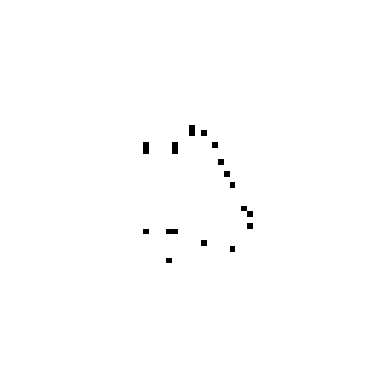

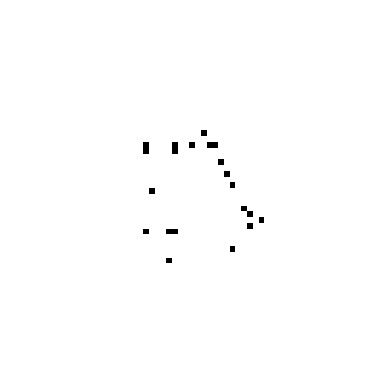

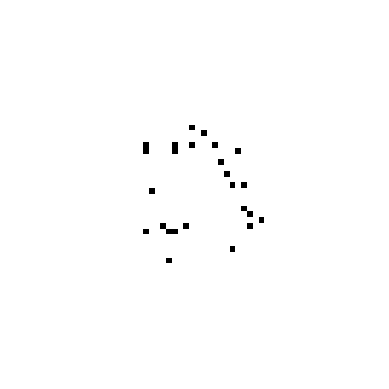

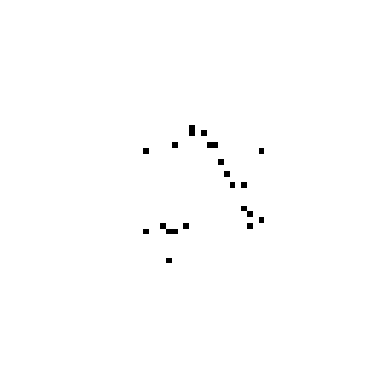

In [408]:
blank = np.ones(64*64)
imgtest = images[15]

restore_flat = dbm.reconstruct(blank)
restore = restore_flat.reshape((64, 64))
plt.imshow(restore, cmap='gray')  # Use grayscale color map
plt.axis('off')  # Hide axes
plt.show()

# restore_flat = dbm.reconstruct(images[15])
# restore = restore_flat.reshape((64, 64))
# plt.imshow(restore, cmap='gray')  # Use grayscale color map
# plt.axis('off')  # Hide axes
# plt.show()

# restore_flat = dbm.reconstruct(blank)
# restore = restore_flat.reshape((64, 64))
# plt.imshow(restore, cmap='gray')  # Use grayscale color map
# plt.axis('off')  # Hide axes
# plt.show()

# restore_flat = dbm.reconstruct(images[15])
# restore = restore_flat.reshape((64, 64))
# plt.imshow(images[1].reshape((64,64)), cmap='gray')  # Use grayscale color map
# plt.axis('off')  # Hide axes
# plt.show()

# imgtest = images[0].copy()
# for i in range(len(imgtest)):
#   if random.choice([0,1]) == 1:
#     imgtest[i] = 0.0
#   if random.choice([0,1]) == 1:
#     imgtest[i] = 0.0

# restore_flat = dbm.rbms[0].reconstruct(blank)
# restore = restore_flat.reshape((64, 64))
# plt.imshow(restore, cmap='gray')  # Use grayscale color map
# plt.axis('off')  # Hide axes
# plt.show()

dbm.adapt(images[1], 0.1)

for j in range(3):
  for i in range(100):
    dbm.adapt(blank, 0.1)

  restore_flat = dbm.reconstruct(blank)
  restore = restore_flat.reshape((64, 64))
  plt.imshow(restore, cmap='gray')  # Use grayscale color map
  plt.axis('off')  # Hide axes
  plt.show()